<a href="https://colab.research.google.com/github/ShayaanKhan/UShousing/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

Loading data

In [28]:
home_price_index = pd.read_csv("CSUSHPISA.csv", parse_dates=["DATE"])
fed_funds_rate = pd.read_csv("FEDFUNDS.csv", parse_dates=["DATE"])
cpi = pd.read_csv("CPIAUCSL.csv", parse_dates=["DATE"])
unrate = pd.read_csv("UNRATE.csv", parse_dates=["DATE"])
gdp = pd.read_csv("GDP.csv", parse_dates=["DATE"])
houst = pd.read_csv("HOUST.csv", parse_dates=["DATE"])
income = pd.read_csv("MEHOINUSA672N.csv", parse_dates=["DATE"])
population = pd.read_csv("POP.csv", parse_dates=["DATE"])
construction_costs = pd.read_csv("PCU236211236211.csv", parse_dates=["DATE"])

List of datasets

In [29]:
# List of datasets
datasets = [
    home_price_index,
    fed_funds_rate,
    cpi,
    unrate,
    gdp,
    houst,
    income,
    population,
    construction_costs,
]
dataset_names = [
    "Home Price Index",
    "Federal Funds Rate",
    "Consumer Price Index (CPI)",
    "Unemployment Rate",
    "GDP",
    "Housing Starts",
    "Median Income",
    "Population",
    "Construction Costs",
]


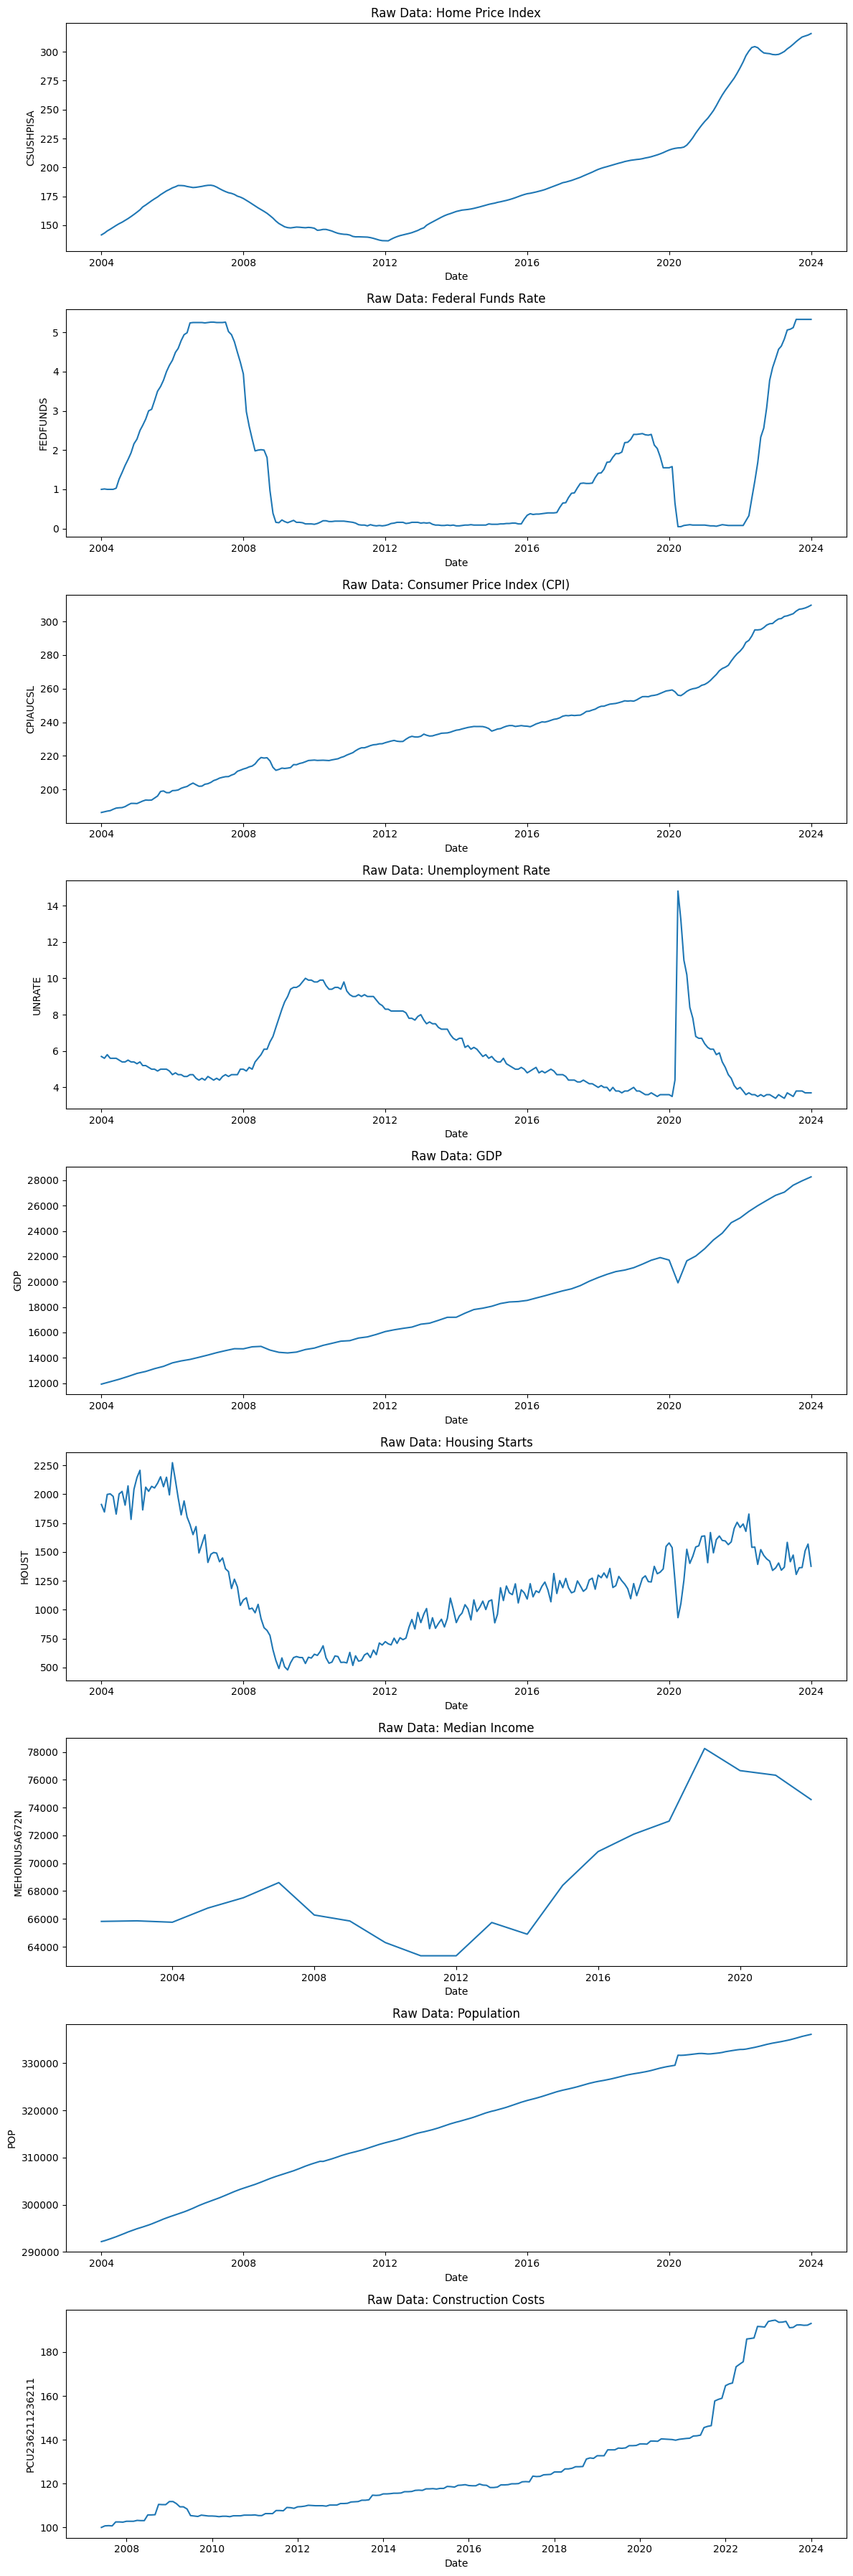

In [30]:

# Plot raw data
fig, axs = plt.subplots(len(datasets), 1, figsize=(12, 36))
for i, df in enumerate(datasets):
    sns.lineplot(x="DATE", y=df.columns[1], data=df, ax=axs[i])
    axs[i].set_title(f"Raw Data: {dataset_names[i]}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel(df.columns[1])
plt.tight_layout()
plt.show()

Common date range: 2007-06-01 00:00:00 to 2022-01-01 00:00:00


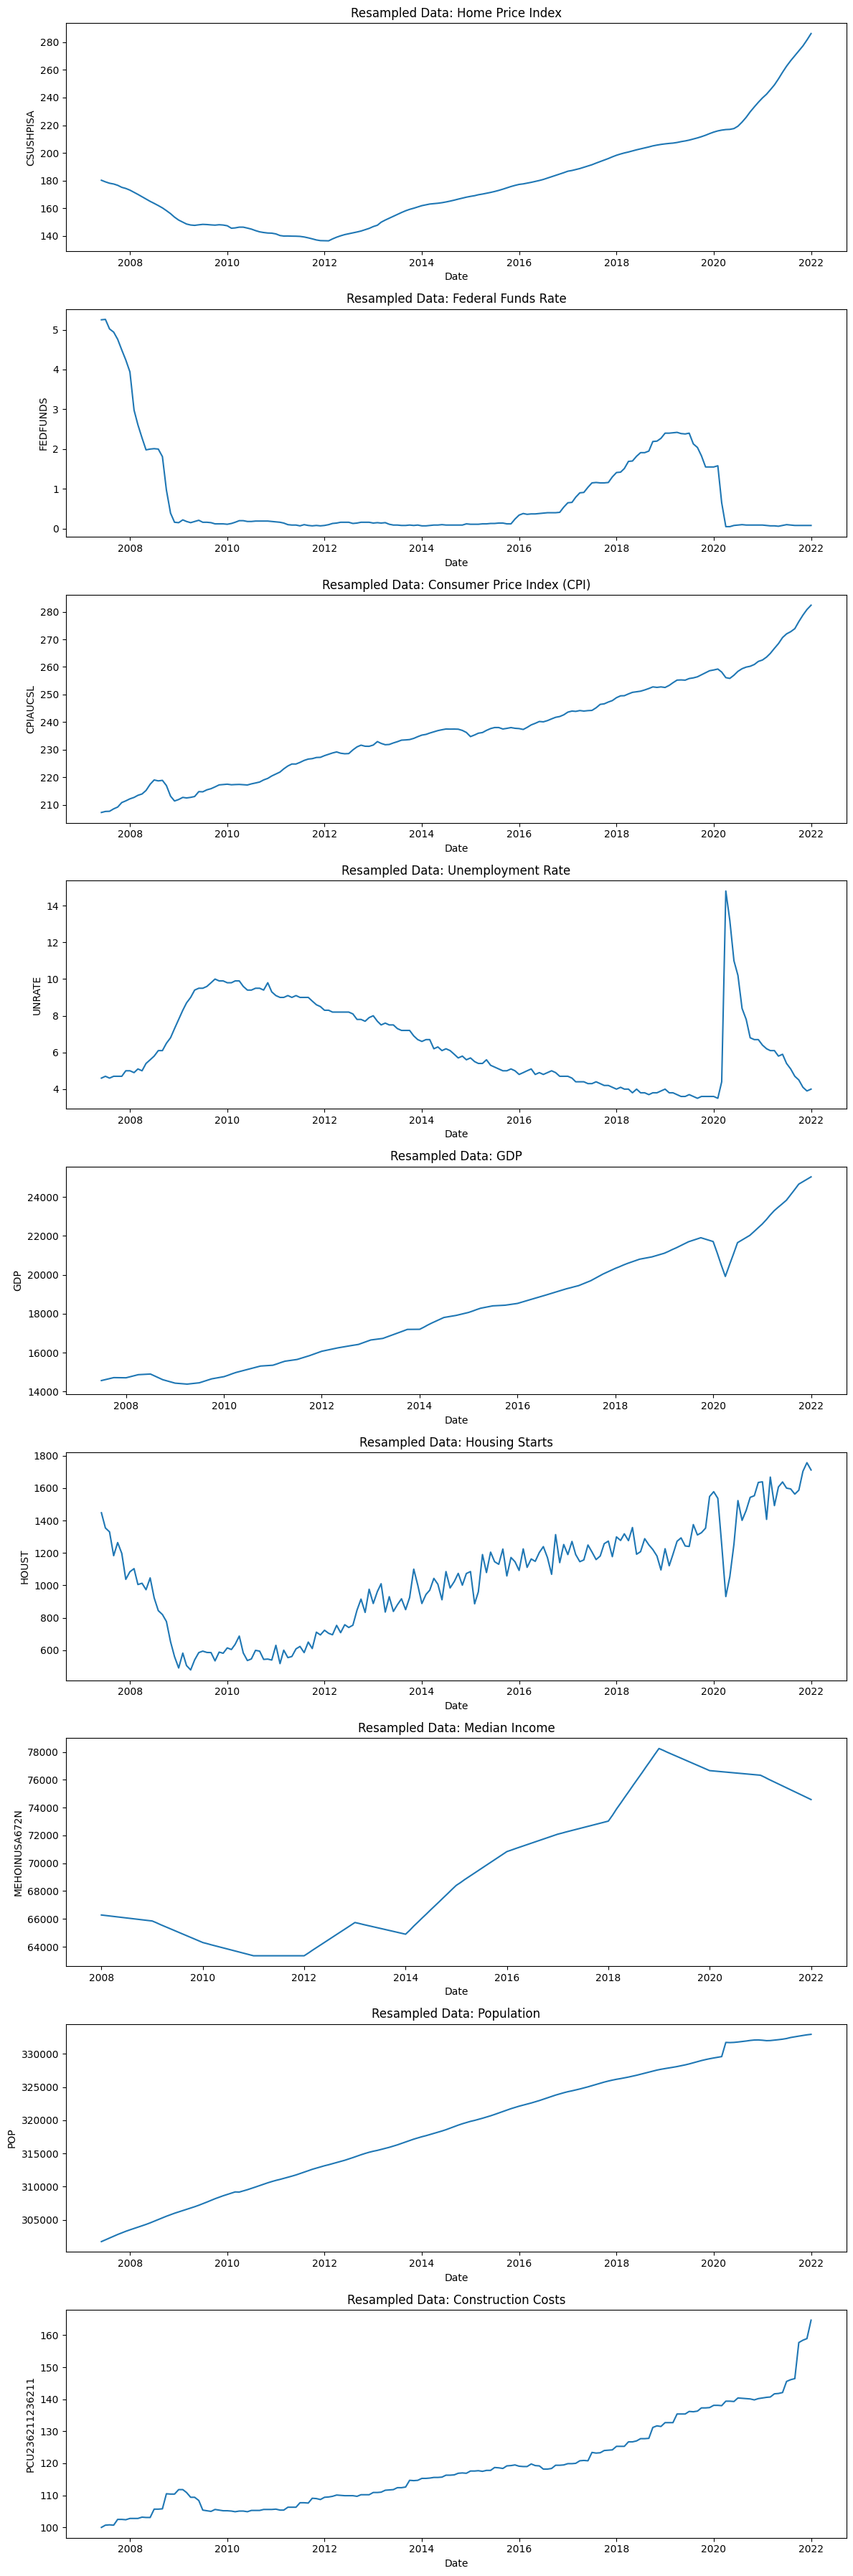

In [32]:
# Function to resample and interpolate data
def resample_and_interpolate(df, start_date, end_date):
    df.set_index("DATE", inplace=True)
    df = df.reindex(
        pd.date_range(start=start_date, end=end_date, freq="MS")
    )  # Monthly start frequency
    df.interpolate(method="linear", inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={"index": "DATE"}, inplace=True)
    return df


# Find common date range
start_date = max([df["DATE"].min() for df in datasets])
end_date = min([df["DATE"].max() for df in datasets])
print(f"Common date range: {start_date} to {end_date}")

# Resample and interpolate each dataset
datasets_resampled = [
    resample_and_interpolate(df, start_date, end_date) for df in datasets
]

# Plot resampled and interpolated data
fig, axs = plt.subplots(len(datasets_resampled), 1, figsize=(12, 36))
for i, df in enumerate(datasets_resampled):
    sns.lineplot(x="DATE", y=df.columns[1], data=df, ax=axs[i])
    axs[i].set_title(f"Resampled Data: {dataset_names[i]}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel(df.columns[1])
plt.tight_layout()
plt.show()

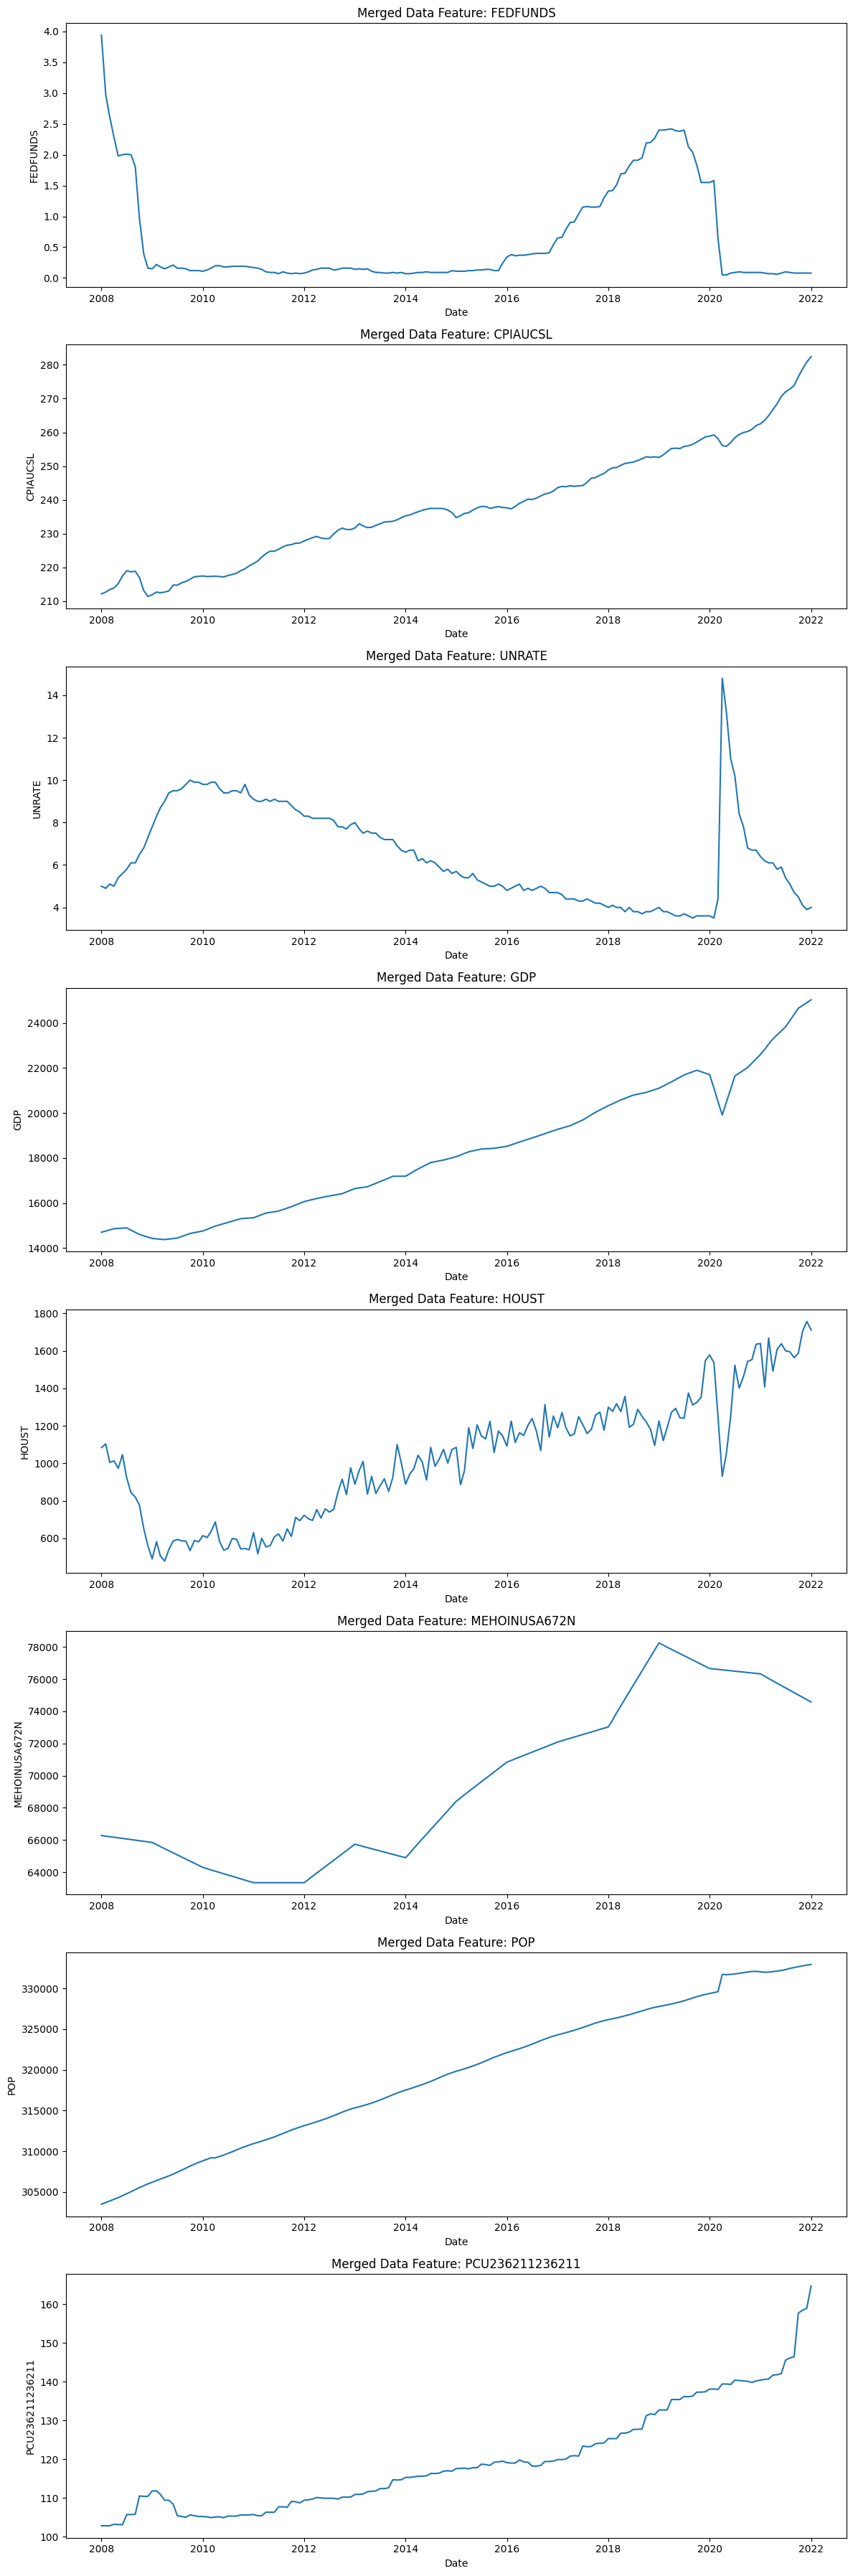

In [34]:
# Merge datasets
merged_data = datasets_resampled[0]
for df in datasets_resampled[1:]:
    merged_data = merged_data.merge(df, on="DATE")

# Drop missing values if any remain after interpolation
merged_data.dropna(inplace=True)

# Plot merged data
features = [
    "FEDFUNDS",
    "CPIAUCSL",
    "UNRATE",
    "GDP",
    "HOUST",
    "MEHOINUSA672N",
    "POP",
    "PCU236211236211",
]
fig, axs = plt.subplots(len(features), 1, figsize=(12, 36))
for i, feature in enumerate(features):
    sns.lineplot(x="DATE", y=feature, data=merged_data, ax=axs[i])
    axs[i].set_title(f"Merged Data Feature: {feature}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel(feature)
plt.tight_layout()
plt.show()

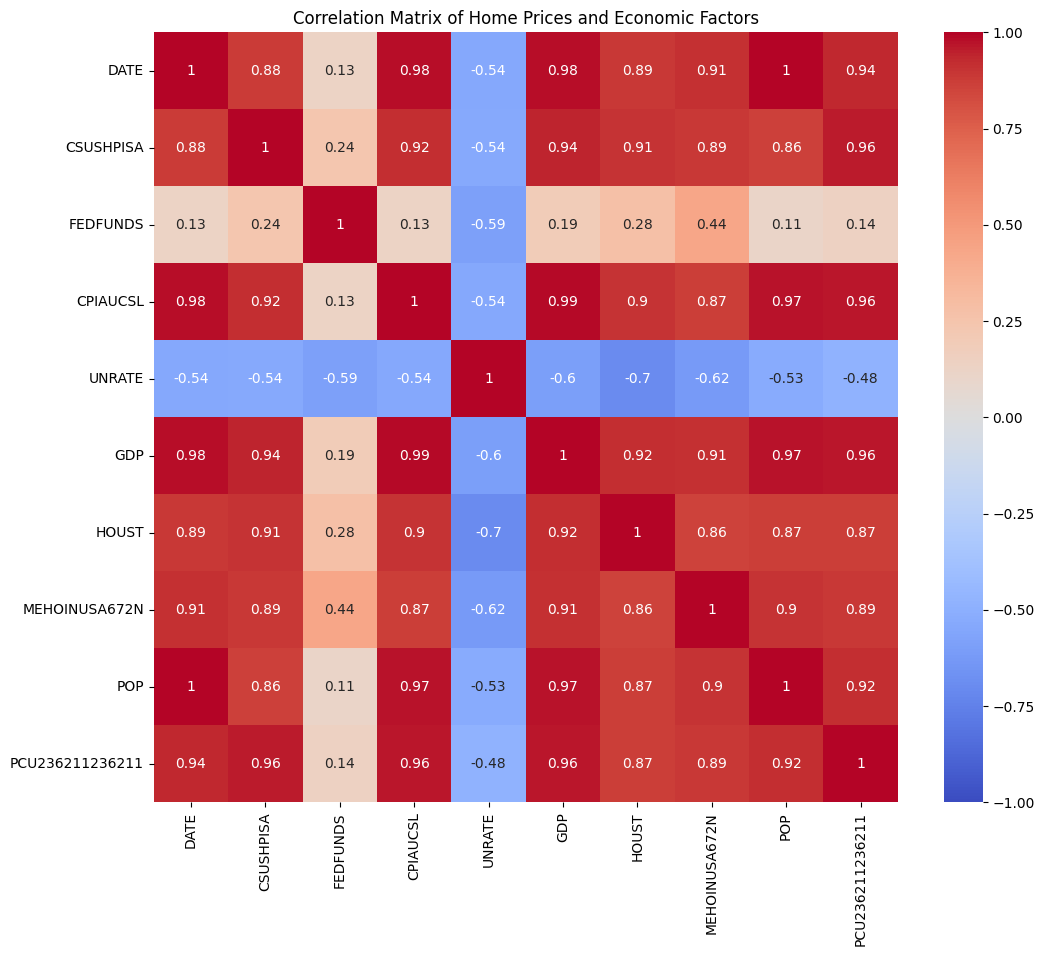

In [35]:
# Calculate correlation matrix
correlation_matrix = merged_data.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Home Prices and Economic Factors")
plt.show()

In [36]:
import statsmodels.api as sm

# Select features and target
X = merged_data[features]
y = merged_data["CSUSHPISA"]

# Add constant for intercept
X_with_const = sm.add_constant(X)

# Fit OLS model
ols_model = sm.OLS(y, X_with_const).fit()

# Print summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:              CSUSHPISA   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     826.5
Date:                Wed, 24 Jul 2024   Prob (F-statistic):          6.38e-126
Time:                        18:21:46   Log-Likelihood:                -525.67
No. Observations:                 169   AIC:                             1069.
Df Residuals:                     160   BIC:                             1098.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1051.3787     80.962     

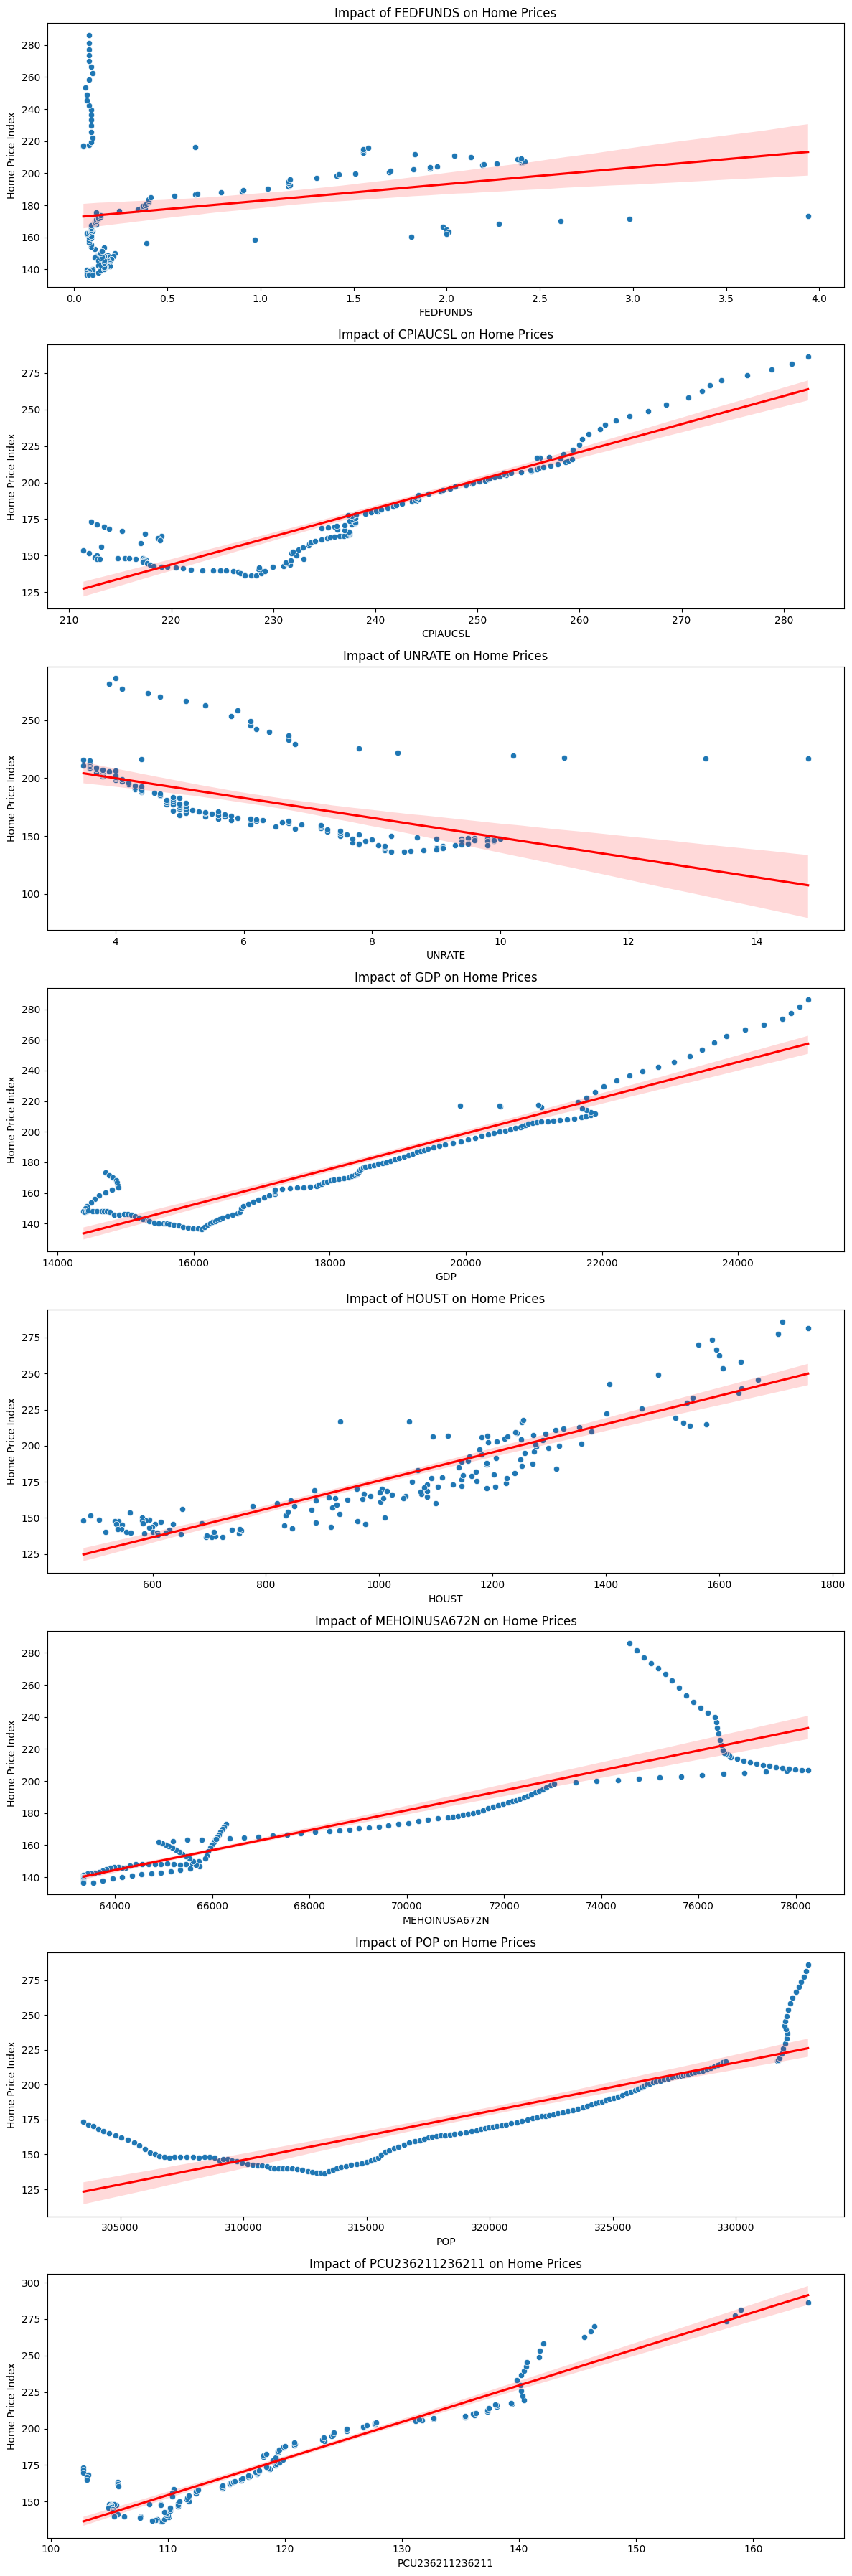

In [37]:
# Plot each feature against home prices
fig, axs = plt.subplots(len(features), 1, figsize=(12, 36))
for i, feature in enumerate(features):
    sns.scatterplot(x=feature, y="CSUSHPISA", data=merged_data, ax=axs[i])
    sns.regplot(
        x=feature,
        y="CSUSHPISA",
        data=merged_data,
        ax=axs[i],
        scatter=False,
        color="red",
    )
    axs[i].set_title(f"Impact of {feature} on Home Prices")
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("Home Price Index")
plt.tight_layout()
plt.show()

R2 Score: 0.9798766134800448
Mean Squared Error: 26.21691611576069


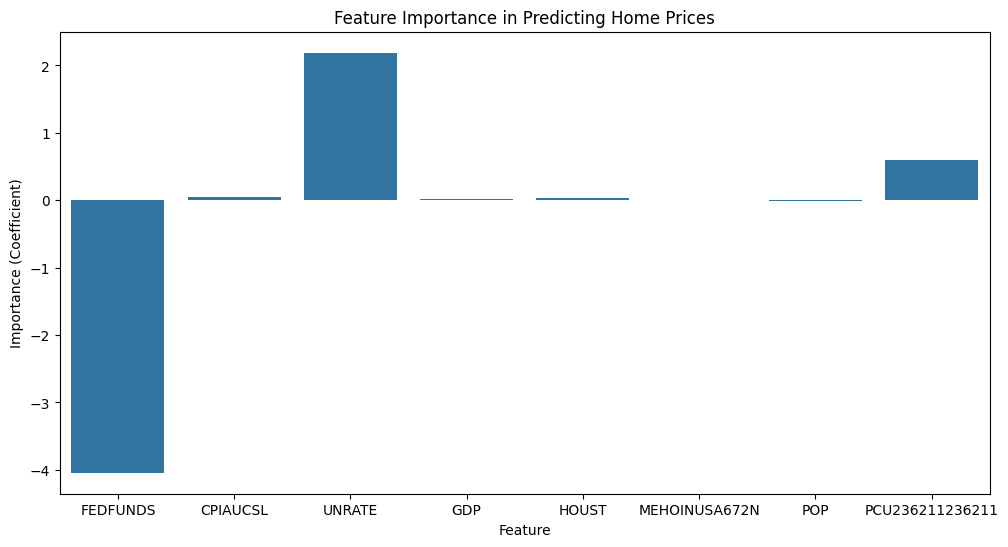

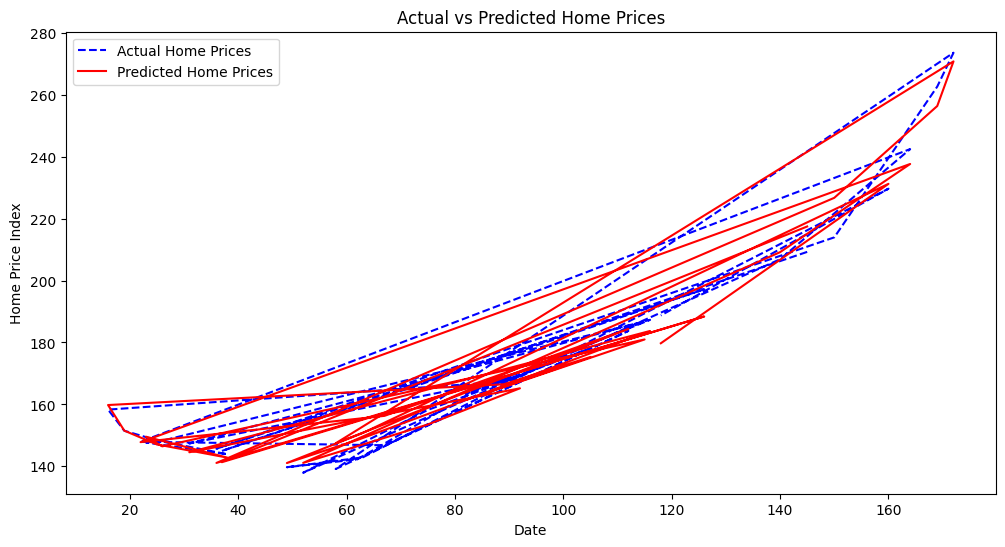

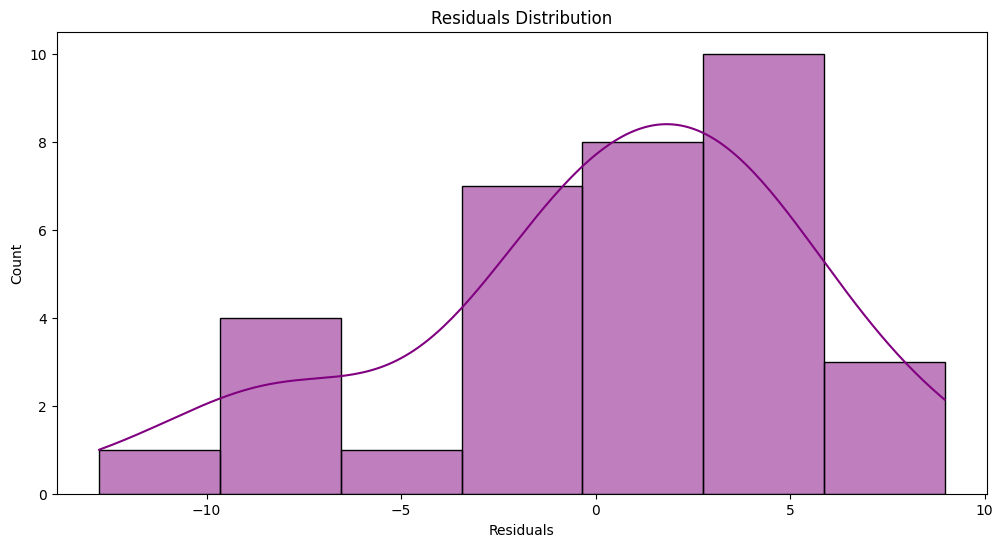

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")

# Get feature importance
importance = model.coef_

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=features, y=importance)
plt.title("Feature Importance in Predicting Home Prices")
plt.xlabel("Feature")
plt.ylabel("Importance (Coefficient)")
plt.show()

# Plot actual vs predicted home prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Home Prices", color="blue", linestyle="--")
plt.plot(
    y_test.index, y_pred, label="Predicted Home Prices", color="red", linestyle="-"
)
plt.xlabel("Date")
plt.ylabel("Home Price Index")
plt.title("Actual vs Predicted Home Prices")
plt.legend()
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color="purple")
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.show()